In [2]:
import pandas as pd
temp_rain_soil = pd.read_csv("../../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:00:00,14.0,0.0,37.51600,10.400
2018-07-07 12:00:00,15.0,0.0,37.52375,10.600
2018-07-07 13:00:00,16.0,0.0,37.57200,10.700
2018-07-07 14:00:00,16.0,0.0,37.34300,10.725
2018-07-07 15:00:00,16.0,0.0,37.35050,10.950


In [3]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90
2023-08-23 03:00:00,11.0,0.0,50.85500,11.65
2023-08-23 04:00:00,10.0,0.0,50.95325,11.60


In [4]:
# Resample to daily mean values
df_daily = temp_rain_soil.resample('D').mean()

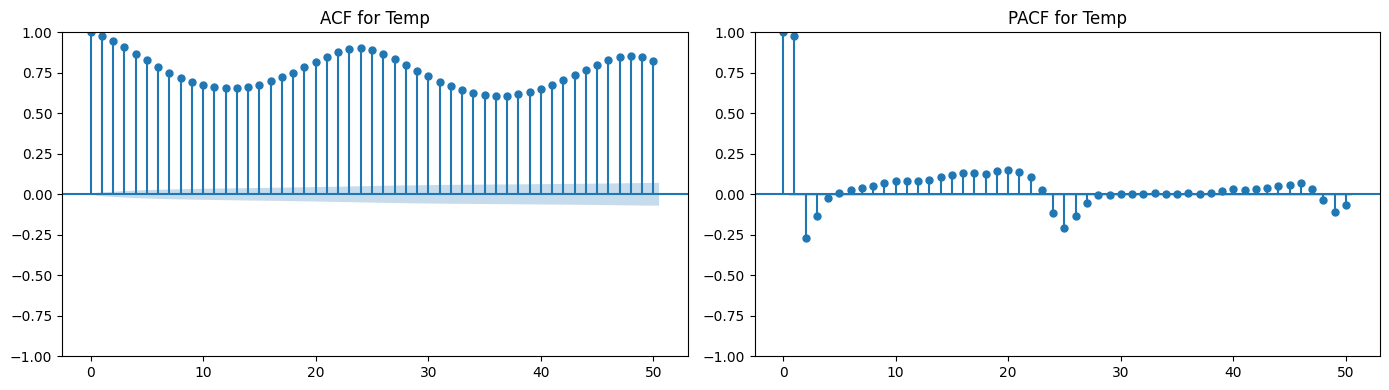

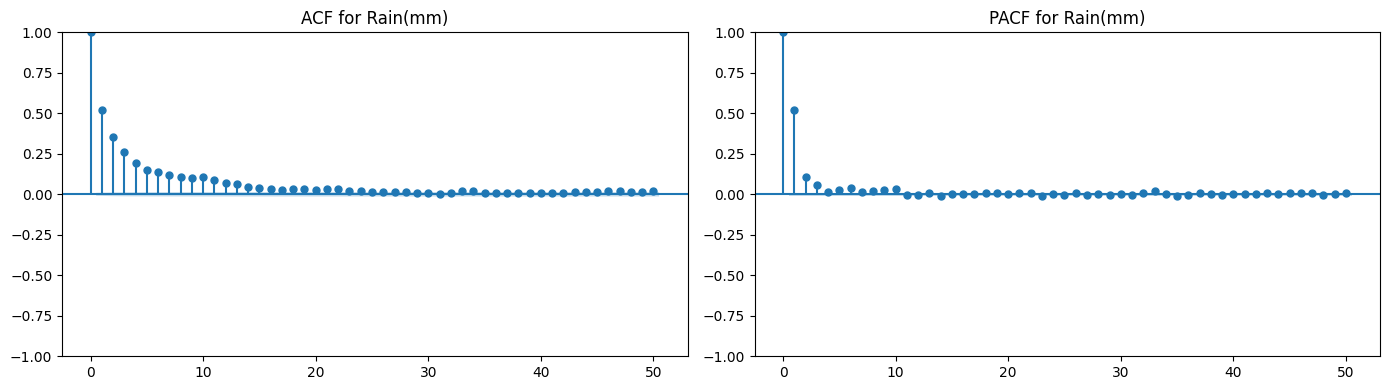

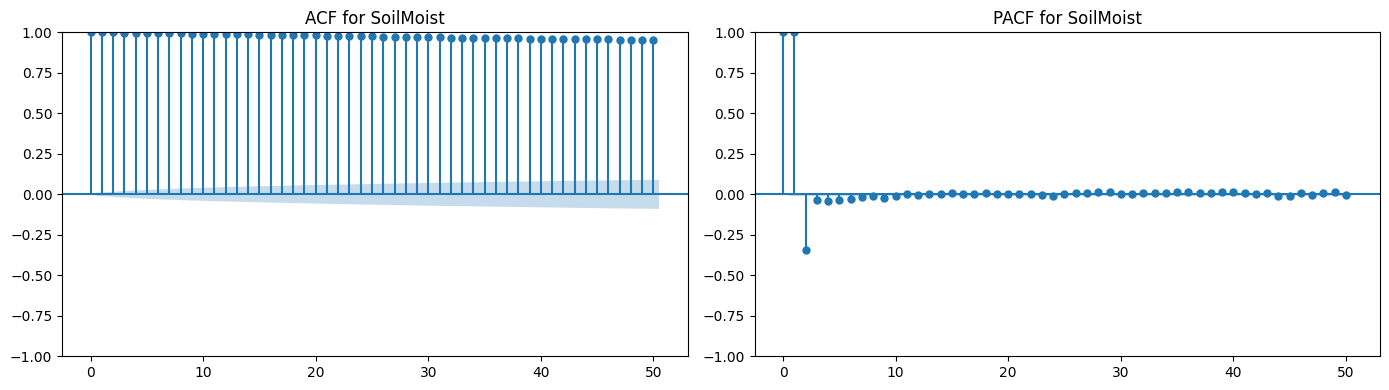

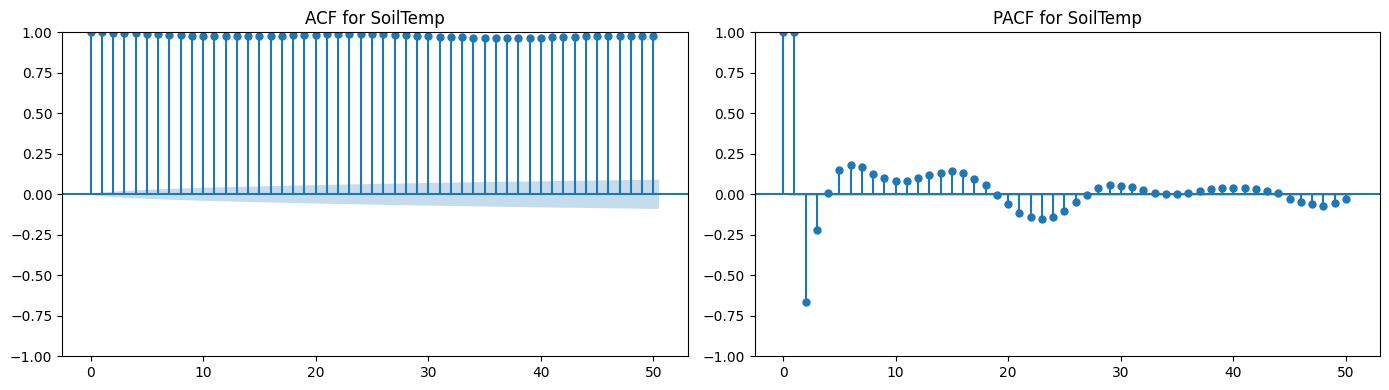

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

variables = ['Temp', 'Rain(mm)', 'SoilMoist', 'SoilTemp']

# Plot ACF and PACF for each variable
for var in variables:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(temp_rain_soil[var], lags=50, ax=ax1, title=f'ACF for {var}')
    plot_pacf(temp_rain_soil[var], lags=50, ax=ax2, title=f'PACF for {var}')
    plt.tight_layout()
    plt.show()

In [6]:
from statsmodels.tsa.stattools import acf, pacf

lags = 50
for column in temp_rain_soil.columns.difference(['Year', 'Month']):
    # Calculate ACF and PACF
    acf_values = acf(temp_rain_soil[column], nlags=lags)
    pacf_values = pacf(temp_rain_soil[column], nlags=lags)
    
    
    # Print the first few ACF and PACF values
    print(f"ACF values for {column}:")
    print(acf_values[:10])
    print(f"\nPACF values for {column}:")
    print(pacf_values[:10])
    print("\n------------------------------------------\n")

ACF values for Rain(mm):
[1.         0.52340482 0.35116711 0.26083597 0.19037535 0.15219257
 0.13970096 0.11782222 0.10480171 0.10253506]

PACF values for Rain(mm):
[1.         0.52341646 0.10635564 0.05700573 0.01696205 0.02503851
 0.03868135 0.01386114 0.01760747 0.02602882]

------------------------------------------

ACF values for SoilMoist:
[1.         0.99962199 0.99898584 0.99823986 0.99742009 0.99654091
 0.99560788 0.99463377 0.99362852 0.99259023]

PACF values for SoilMoist:
[ 1.          0.99964423 -0.36306526 -0.02659986 -0.04617544 -0.03379739
 -0.03294185 -0.01436282 -0.01054759 -0.02182449]

------------------------------------------

ACF values for SoilTemp:
[1.         0.99937783 0.99792584 0.99577103 0.99307651 0.99005264
 0.9869144  0.98386624 0.98108016 0.97869393]

PACF values for SoilTemp:
[ 1.          0.99940006 -0.69214888 -0.20800384  0.02612299  0.16882103
  0.19078365  0.17122774  0.12445878  0.09463577]

------------------------------------------

ACF value

Rain(mm):

ACF shows significant autocorrelation at the first lag, indicating that rainfall tends to be correlated with itself at one-hour intervals.
PACF shows a significant value at the first lag, suggesting that the previous hour's rainfall has a direct impact on the current hour's rainfall.
SoilMoist:

Both ACF and PACF show very high values for the first few lags, indicating strong autocorrelation and partial autocorrelation. This suggests that soil moisture values are highly persistent and influenced by their immediate past values.
SoilTemp:

Similar to SoilMoist, SoilTemp also shows strong autocorrelation and partial autocorrelation, indicating persistence and influence from past values.

# Check for Stationarity and Determine d (Order of Differencing):

In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(temp_rain_soil['Rain(mm)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -31.43020267697512
p-value: 0.0
Critical Values:
	1%: -3.4304956140767477
	5%: -2.8616043582706956
	10%: -2.5668042558069497


The Dickey-Fuller test results indicate that the series Rain(mm) is stationary. 
The ADF statistic is significantly lower than the critical values at the 1%, 5%, and 10% levels, and the p-value is very low (close to zero). 

This suggests strong evidence against the null hypothesis, indicating that the series is indeed stationary.

# Arima Model

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


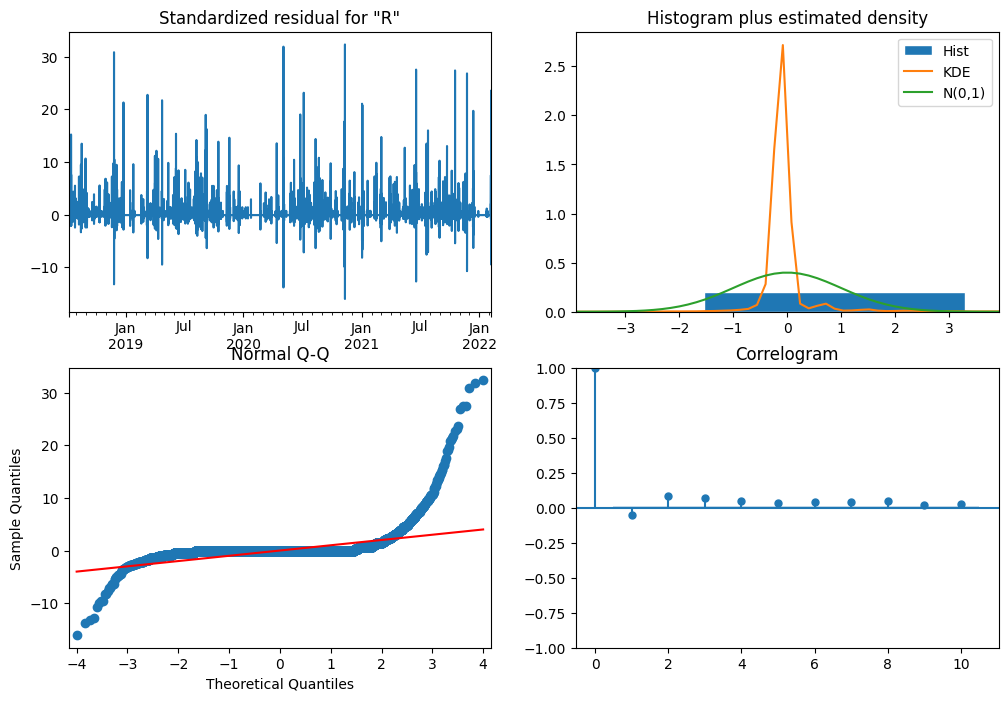

AIC for Rain(mm): 60404.36536527256
BIC for Rain(mm): 60429.43497251471


In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_data_rain, test_data_rain = train_test_split(temp_rain_soil['Rain(mm)'], test_size=0.3, shuffle=False)
model_rain = ARIMA(train_data_rain, order=(1, 0, 0))
model_fit_rain = model_rain.fit()

model_fit_rain.plot_diagnostics(figsize=(12, 8))
plt.show()

# Print AIC and BIC for Rain(mm)
print("AIC for Rain(mm):", model_fit_rain.aic)
print("BIC for Rain(mm):", model_fit_rain.bic)

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt

forecast_steps = len(test_data_rain)
prediction = model_fit_rain.forecast(steps=forecast_steps)

rmse = sqrt(mean_squared_error(test_data_rain, prediction))
print(f"RMSE: {rmse}")

RMSE: 1.3027941381051518


In [11]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


rmse = np.sqrt(mean_squared_error(test_data_rain, prediction))
mae = mean_absolute_error(test_data_rain, prediction)
mse = mean_squared_error(test_data_rain, prediction)
r2 = r2_score(test_data_rain, prediction)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R2 Score:", r2)

Root Mean Squared Error (RMSE): 1.3027941381051518
Mean Absolute Error (MAE): 0.3140234668405281
Mean Squared Error (MSE): 1.6972725662811454
R2 Score: -0.006190950863655287


In [12]:
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(temp_rain_soil['SoilMoist'], test_size=0.3, shuffle=False)
# print(f"Train data length: {len(train_data)}")
# print(f"Test data length: {len(test_data)}")

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


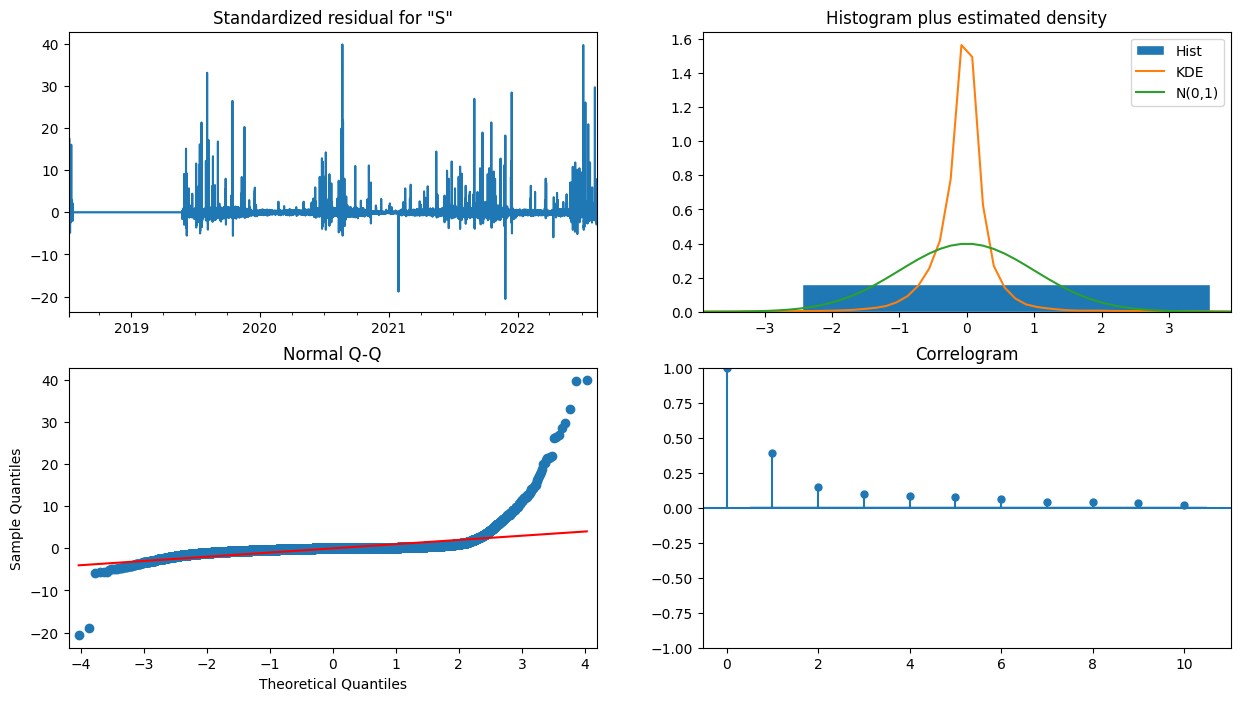

AIC for SoilMoist: -56098.71143586783
BIC for SoilMoist: -56073.24128212475


In [13]:
from sklearn.model_selection import train_test_split
train_data_soil_moist, test_data_soil_moist = train_test_split(temp_rain_soil['SoilMoist'], test_size=0.2, shuffle=False)

model_soil_moist = ARIMA(train_data_soil_moist, order=(1, 0, 0))
model_fit_soil_moist = model_soil_moist.fit()

model_fit_soil_moist.plot_diagnostics(figsize=(15,8))
plt.show()

print("AIC for SoilMoist:", model_fit_soil_moist.aic)
print("BIC for SoilMoist:", model_fit_soil_moist.bic)

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

forecast_steps = len(test_data_soil_moist)
prediction = model_fit_soil_moist.forecast(steps=forecast_steps)

rmse = sqrt(mean_squared_error(test_data_soil_moist, prediction))
print(f"RMSE: {rmse}")


RMSE: 5.206072283233085


In [15]:
rmse = np.sqrt(mean_squared_error(test_data_soil_moist, prediction))
mae = mean_absolute_error(test_data_soil_moist, prediction)
mse = mean_squared_error(test_data_soil_moist, prediction)
r2 = r2_score(test_data_soil_moist, prediction)
print("Soil Moisture Root Mean Squared Error (RMSE):", rmse)
print("Soil Moisture Mean Absolute Error (MAE):", mae)
print("Soil Moisture Mean Squared Error (MSE):", mse)
print("Soil Moisture R2 Score:", r2)

Soil Moisture Root Mean Squared Error (RMSE): 5.206072283233085
Soil Moisture Mean Absolute Error (MAE): 4.55582301194101
Soil Moisture Mean Squared Error (MSE): 27.103188618247746
Soil Moisture R2 Score: -3.651678037091264


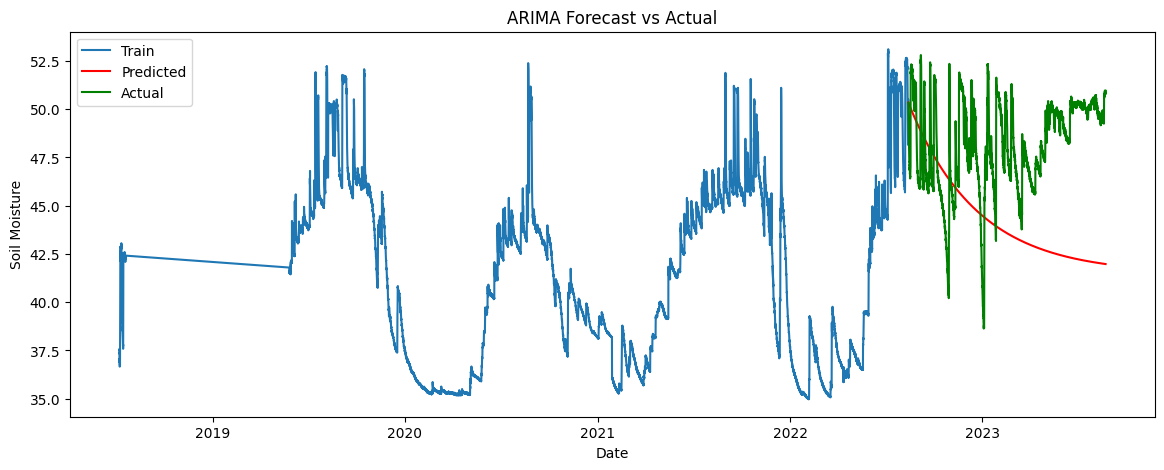

In [16]:
# Plotting
plt.figure(figsize=(14, 5))
plt.plot(train_data_soil_moist, label='Train')
plt.plot(test_data_soil_moist.index, prediction, color='red', label='Predicted')
plt.plot(test_data_soil_moist, color='green', label='Actual')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

# explore other orders selection using grid search

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=59775.153, Time=53.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67587.661, Time=3.56 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=60766.170, Time=1.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=62663.520, Time=5.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=59949.183, Time=14.98 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59923.147, Time=16.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=59822.742, Time=63.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=66.60 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=59994.257, Time=8.54 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=59909.449, Time=26.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=59813.750, Time=43.46 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=114.82 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=59680.366, Time=295.96 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=59743.845, Time=60.55 sec
 ARIMA(2,0,1)(0,0,0

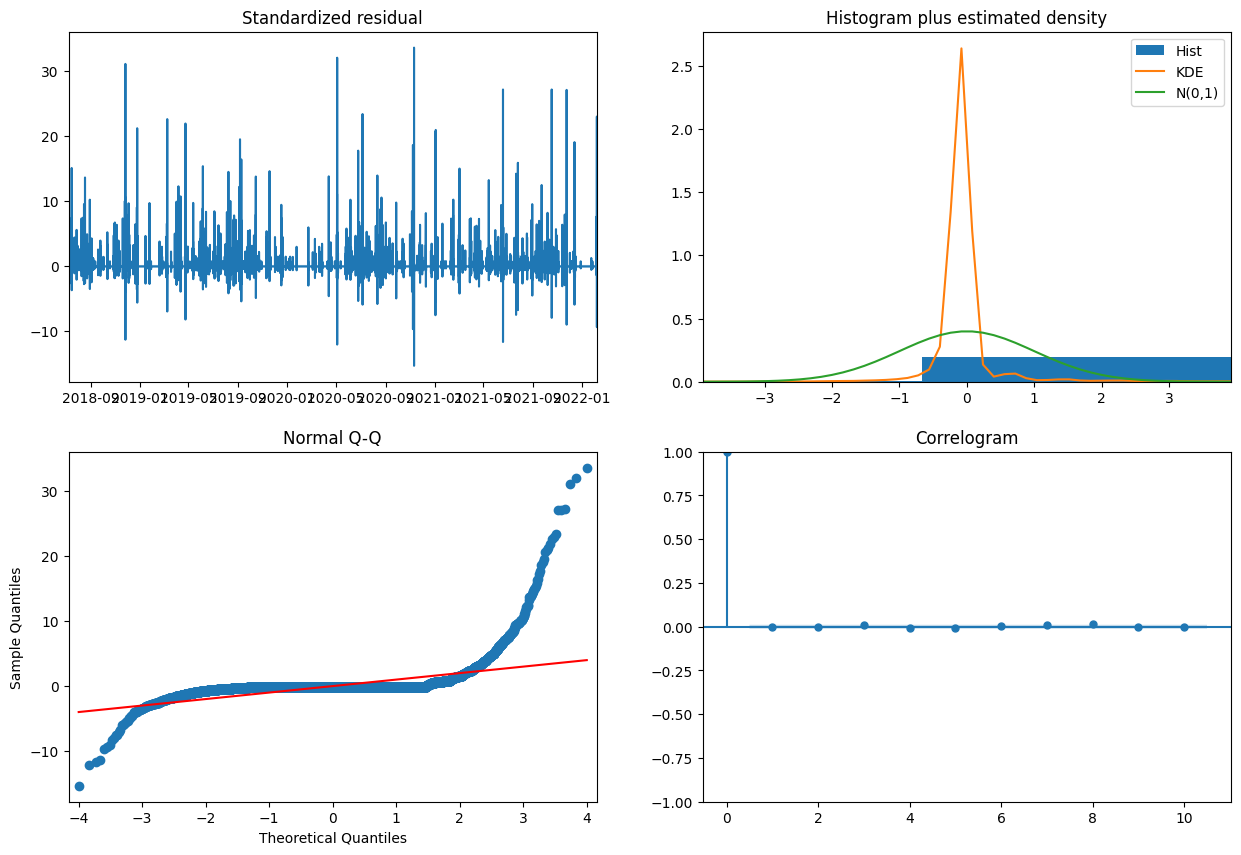

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                31462
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -29834.183
Date:                Fri, 28 Jun 2024   AIC                          59680.366
Time:                        06:47:49   BIC                          59730.505
Sample:                    07-07-2018   HQIC                         59696.417
                         - 02-07-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.001      4.529      0.000       0.002       0.004
ar.L1          1.5324      0.015    104.644      0.000       1.504       1.561
ar.L2         -0.5552      0.011    -48.470      0.0

In [17]:
from pmdarima import auto_arima

model_rain = auto_arima(train_data_rain, seasonal=False, trace=True)
model_fit_rain = model_rain.fit(train_data_rain)

model_fit_rain.plot_diagnostics(figsize=(15, 10))
plt.show()
print(model_fit_rain.summary())
print("AIC for Rain(mm):", model_fit_rain.aic())
print("BIC for Rain(mm):", model_fit_rain.bic())


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-62164.099, Time=1094.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-56101.743, Time=6.73 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-62065.043, Time=75.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-61434.091, Time=388.98 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-56103.371, Time=10.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-62166.117, Time=641.41 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-62163.811, Time=160.91 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-62161.893, Time=2126.38 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-62166.101, Time=892.88 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-62159.394, Time=1380.60 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-62227.916, Time=186.57 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-62229.451, Time=86.56 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-62227.919, Time=217.77 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-62225.920, Time=227.94 sec
 ARIMA(0

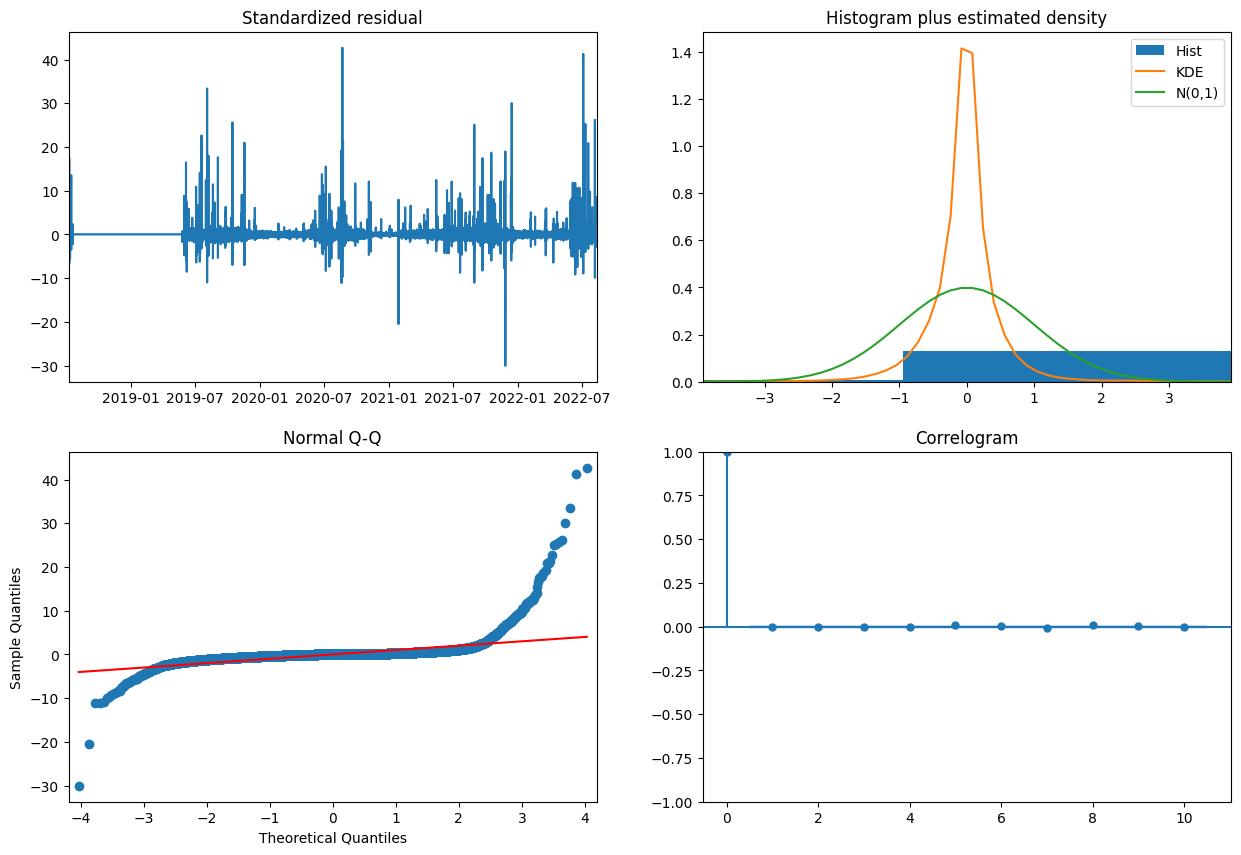

AIC for Seasonal Rain(mm): -62241.21066632085
BIC for Seasonal Rain(mm): -62198.76054914316


In [18]:
model_soil_seasonal = auto_arima(train_data_soil_moist, seasonal=True, m=12, trace=True)
model_fit_soil_seasonal = model_soil_seasonal.fit(train_data_soil_moist)

print(model_fit_soil_seasonal.summary())
model_fit_soil_seasonal.plot_diagnostics(figsize=(15, 10))
plt.show()

print("AIC for Seasonal Rain(mm):", model_fit_soil_seasonal.aic())
print("BIC for Seasonal Rain(mm):", model_fit_soil_seasonal.bic())

# Sarima Model


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=59684.436, Time=336.07 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=66669.519, Time=7.47 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=60399.604, Time=29.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=62046.415, Time=34.95 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=67587.661, Time=3.10 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=59681.265, Time=370.40 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=59680.366, Time=136.00 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=59681.109, Time=314.92 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=59743.845, Time=27.82 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=59736.097, Time=42.33 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=59712.627, Time=146.60 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=59687.447, Time=144.53 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=59765.285, Time=22.81 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=59729.123, Ti

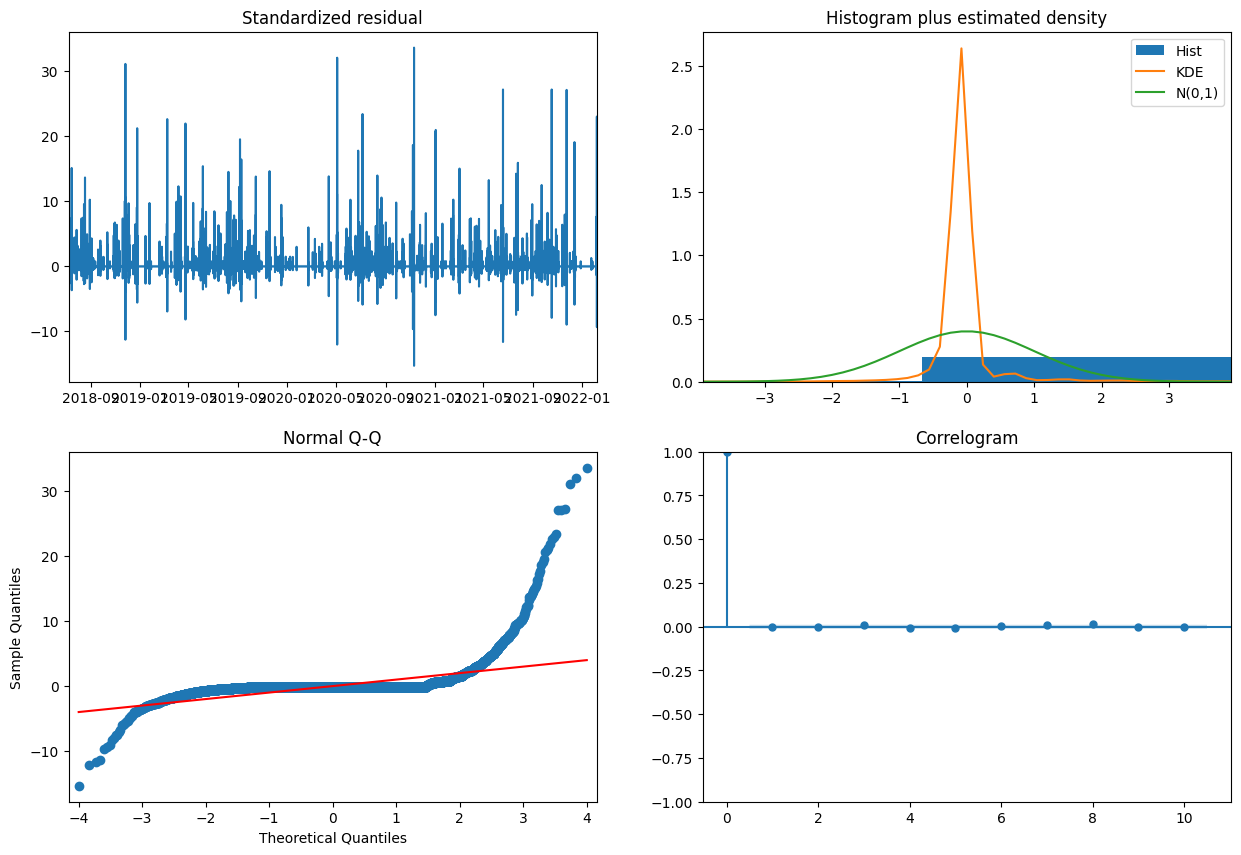

AIC for Seasonal Rain(mm): 59680.36579316315
BIC for Seasonal Rain(mm): 59730.50500764745


In [19]:
model_rain_seasonal = auto_arima(train_data_rain, seasonal=True, m=12, trace=True)
model_fit_rain_seasonal = model_rain_seasonal.fit(train_data_rain)

print(model_fit_rain_seasonal.summary())
model_fit_rain_seasonal.plot_diagnostics(figsize=(15, 10))
plt.show()

print("AIC for Seasonal Rain(mm):", model_fit_rain_seasonal.aic())
print("BIC for Seasonal Rain(mm):", model_fit_rain_seasonal.bic())